# Multi-objective Bayesian optimization for Approximate Nearest Neighbors search (Annoy, HNSW, LSH)

In our previous posts we explored multi-objective Bayesian optimization (MOBO) applied to a [synthetic dataset]() and to the canonical [Credit Card Fraud dataset](). While we learned a lot from these toy experiments, we wanted to consider a more realistic use case. A good candidate for MOBO has several qualities: 
1. it should be an expensive-to-run function that could potentially benefit from efficient optimization
2. it should have multiple objectives that one might realistically strive to optimize
3. and, ideally, it should have real-world utility and a more challenging dataset

One such application that fits the bill is nearest neighbor search. In nearest neighbor search we typically have an entity represented by a vector and our goal is to indentify similar entities by finding those vectors closest to our query vector. In what follows, we explore several classes of approximate nearest neighbor search algorithms and share what we learned.  


## Nearest Neighbor Search
Nearest neighbor search is a ubiquitous and fundamental tool. It can be used to detect spam, find similar images, recognize handwritten digits, find semantically similar pieces of text, and recommend articles, music, or videos. Just about any interaction on the internet involves the application of a nearest neighbor search! A brute force solution computes the exact distance between every single pair of objects in our database. However, modern applications typically require searching over millions of objects, rendering the brute force solution impractically slow.  This has spawned a huge area of research and the development of a wide variety of Approximate Nearest Neighbor (ANN) algorithms that make neighbor searching more efficient - at a price. In many applications an exact solution, while nice to have, is not a necessity when a good approximation will work well for most instances. ANN algorithms thus sacrifice accuracy (and sometimes memory) to increase the efficiency of the search. 
Therefore, these algorithms naturally demand trade-offs between latency, accuracy and memory footprint. 


### ANN Primer
The core idea behind the majority of ANN algorithms is that we can find an approximate solution by comparing our query point to a _subset_ of points in our database, rather than exhaustively comparing to _all_ points in our database (the brute force solution). The larger the subset we search over, the more likely we are to find the true set of nearest neighbors -- but it will take more time. If we allow the subset to equal the size of our database, we should retrieve the exact solution -- but the query would take so long that we'd lose all the users on our website who would get bored of waiting and churn off! 

Thus, the main objective for many ANN algorithms is to devise clever ways to reduce the number of items to be scored in search of the best neighbors. Often this is accomplished by proficiently partitioning the points in our database. This partitioning can be accomplished in several ways, which we can roughly group into three families of ANN algorithms.    

### All in the fANNmily 

1. **Tree-based** \
    Trees are another classic approach to nearest neighbor search. Data points are divided hierarchically into cells and neighbors are found by traversing the tree(s). This category includes classics like k-d trees and ball trees. Like graph methods, tree-based methods have a long construction time which is especially noticeable with very large datasets.  
2. **Graph-based** \
    These algorithms first build a graph in which each item in the database is a node with the vertices representing the distance between nodes. Fast neighbor search is typically performed through greedy graph traversal. Dozens of algorithms exist in this category, including variations on graph construction and greedy  traversal methods. 
3. **Hashing-based** \
    These algorithms work by projecting the data points into lower-dimensional space using hashing. These hashes are "locality-sensitive" such that nearby points fall into the same hash bucket with high probability. Finding neighbors requires identifying bucket(s) that match the query hash. 
 


## The game plANN 
(Alright, we'll stop with the puns.) In this notebook we'll walk through how to apply multi-objective Bayesian optimization techniques to several ANN algorithms: **Annoy** (tree-based), **HNSW** (graph-based), and **LSH** (hashing-based), one from each of the ANN families above.  In each experiment we'll consider three objectives: accuracy, latency, and memory footprint. Our goal will be to find the 3D Pareto frontier that defines the trade-offs between these objectives. For each experiment, we'll perform multi-objective Bayesian optimization (MOBO) with the Optuna library and compare that to a quasi-random search. 

First, let's take care of some installs, imports, and the data that we'll use for this notebook. 

In [ ]:
# First lets take care of stuff that all algos will use
!pip install -r requirements.txt

In [2]:
import os
import psutil
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import annoy
import hnswlib
import falconn
import optuna
from ann_benchmarks_dataset import get_dataset

The next cell will take care of our data needs. We'll be using GloVe word embeddings generated from tweets. In order to compare our predicted (approximate) nearest neighbors to ground truth, we'll need to use a brute force method to compute what the ground truth neighbors are for a test set. Luckily, this work has already been done by the authors of the [ANN_benchmarks](https://github.com/erikbern/ann-benchmarks/tree/3aedc8a314aba1c7d42b64e7ff9f3944e6822a93) library. They even include a helpful function for automatically downloading a train and test set along with ground truth neighbors to compare against. 

In [3]:
# Load data for all experiments
dataset, _ = get_dataset('glove-100-angular')

# the data is structured as hd5f so we cast them to np.arrays
# there are 1.2M word embeddings in the train set
X_train = np.array(dataset['train'])
# there are 10K word embeddings in the test set
X_test = np.array(dataset['test'])
# these are the brute-force-computed ground truth neighbors for each item in the test set
X_test_neighbors = np.array(dataset['neighbors'])

These constants will be used throughout the notebook. For each experiment we'll look for the 10 nearest neighbors to a given query point. Each experiment will run for a minimum of 50 trials. 

In [6]:
# for all experiments, we'll look for the 10 nearest neighbors
N_NEIGHBORS = 10
# each experiment will also be composed fo 50 rounds of optimization
N_TRIALS = 50

Next, we have a couple of utility functions for measuring the memory usage of our algorithms, computing recall, and formatting the results of an experiment. 

In [20]:
def get_memory_usage(pid):
    # given a process ID, return the memory usage in MB
    return psutil.Process(pid).memory_info().rss / 1024 ** 2

def compute_recall(predicted_neighbors, true_neighbors):
    # given a list of neighbor predictions and ground truth neighbors
    # compute the average recall
    score = 0
    for prediction, truth in zip(predicted_neighbors, true_neighbors):
        score += len(set(prediction).intersection(truth)) / N_NEIGHBORS
    return score / len(true_neighbors)

def cast_as_df(optuna_experiment, experiment_type, algorithm_name):
    return (
        optuna_experiment
        .trials_dataframe()
        .rename(columns={"values_0": "recall", "values_1": "query_time", "values_2":"index_size"})
        .assign(experiment = experiment_type,
                algorithm = algorithm_name
               )
    )

We also include a few plotting routines. 

In [5]:
def threeD_fig(dfs):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')

    for df in dfs:
        ax.scatter3D(df["recall"], df["query_time"]*1e3, df['index_size'], alpha=0.5, label=df.reset_index().experiment[0])
    ax.set_xlabel("Recall", fontsize=12)
    ax.set_ylabel("Query time (ms)", fontsize=12)
    ax.set_zlabel("Index size (MB)")

    plt.suptitle(f"{df.reset_index().algorithm[0]} Results", fontsize=20)
    plt.tight_layout()

    
def three_panel_fig(dfs):
    fig = plt.figure(figsize=(16,6))

    ax = fig.add_subplot(131)
    for df in dfs:
        ax.scatter(df["recall"], df["query_time"]*1e3, alpha=0.5, label=df.reset_index().experiment[0])
    plt.xlabel("Recall")
    plt.ylabel("Query Time (ms)")
    plt.legend()

    ax = fig.add_subplot(132)
    for df in dfs:
        ax.scatter(df["recall"], df["index_size"], alpha=0.5, label=df.reset_index().experiment[0])
    plt.xlabel("Recall")
    plt.ylabel("Index size (MB)")
    plt.legend();

    ax = fig.add_subplot(133)
    for df in dfs:
        ax.scatter(df["query_time"]*1e3, df["index_size"], alpha=0.5, label=df.reset_index().experiment[0])
    plt.xlabel("Query time (ms)")
    plt.ylabel("Index size (MB)")
    plt.legend();
    
    plt.suptitle(f"{df.reset_index().algorithm[0]} Results", fontsize=20)

## Approximate Nearest Neighbors, Oh Yeah!

No kidding, those words compose the delightful acronym [Annoy](https://github.com/spotify/annoy). Developed by the good people at Spotify for music recommendations, the algorithm behind this library falls under the tree-based methods. While the library's author does a fantastic job describing the algorithm in [this](https://erikbern.com/2015/10/01/nearest-neighbors-and-vector-models-part-2-how-to-search-in-high-dimensional-spaces.html) blog post, we provide a brief overview here (borrowing their figures for illustration). 

At a high level, Annoy works by randomly selecting pairs of datapoints and creates a hyperplane equidistant between them to split the dataset. It does this recursively until the whole space is partitioned and each partition contains `k` datapoints. 

<img src="https://erikbern.com/assets/2015/09/tree-full-K-1024x793.png" style="width:500px;height:400px;">

Next, a binary tree is constructed from these partitions and points that are close to each other in space are likely to be close to each other in the tree as well. 

<img src="https://erikbern.com/assets/2015/09/tree-full-K-graphviz1-1024x404.png" style="width:800px;height:300px;">

This is performed many times until an entire forest is constructed. Neighbors are found by traversing the trees and only computing distances on those datapoints that fall in the same (or nearby) branches. 


### Hyperparameters
There are two main hyperparameters to consider: the number of trees (`n_trees`) to construct during build time, and the number candidate points to inspect (`search_k`) at query time. Increasing the number of trees results in better accuracy but can take more memory. Increasing the number of points to inspect also increases accuracy but takes longer. 

### Code it up
We'll use [Optuna]() to tune these hyperparameters. Below is the function we'll pass to Optuna's optimization engine. Optuna will suggest values for the hyperparameters through the `trial` object passed to the function. The function contains all the necessary pieces to build an Annoy Index and evaluate that index on the test set. The evaluation metrics include a simple computation of recall, as well as memory usage and the average query time for inference on the test set.  

In [7]:
def train_annoy(trial):    
    # initialize the Annoy Index - requires the vector length and metric ('angular' is for cosine similarity)
    ann = annoy.AnnoyIndex(X_train.shape[1], metric='angular')

    # populate the index (build the trees) with train set
    memory_usage_before = get_memory_usage(os.getpid())
    for i, x in enumerate(X_train):
        ann.add_item(i, x.tolist())
    ann.build(n_trees = trial.suggest_int("n_trees", 10, 100))
    # measuring memory usage before and after the build 
    # will give us the size of the index in MB
    index_size = get_memory_usage(os.getpid()) - memory_usage_before

    # run queries for each example in the test set
    t1 = time.time()
    neighbors = []
    for i, x in enumerate(X_test):
        neighbors.append(ann.get_nns_by_vector(x.tolist(), 
                                               N_NEIGHBORS, 
                                               search_k = trial.suggest_int("search_k", 100, 1000)
                                              ))
    # noting the time before and after running our queries will give an
    # approximation of the average query_time
    query_time = (time.time() - t1) / len(X_test)

    recall = compute_recall(neighbors, X_test_neighbors)
    return recall, query_time, index_size

Below we specify the MOTPE (Multi-Objective Trees of Parzen Estimators) algorithm to sample hyperparameter values. In Optuna, the optimization process is called a `study`, and we pass it our sampling strategy and the `direction` we wish to optimize our metrics.  We have three objectives: predictive performance (`recall`), speed (`query_time`), and memory consumption (`index_size`). We want to `maximize` recall and `minimize` the other two. The order should align with the order in which these variables are returned from the training function above. The third line begins the optimization exercise and here we pass it the function we wish to optimize and the number of trials it should run for. 

In [8]:
# Note: this cell takes 20-30 minutes to run
motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler,
                                       directions=["maximize", "minimize", "minimize"])
motpe_experiment.optimize(train_annoy, n_trials=N_TRIALS)

<ipython-input-8-c8caf536b12c>:1: ExperimentalWarning: MOTPESampler is experimental (supported from v2.4.0). The interface can change in the future.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2021-06-24 18:02:42,741] A new study created in memory with name: no-name-bb880729-97b0-4c77-8803-e339148d4e64
[I 2021-06-24 18:03:05,170] Trial 0 finished with values: [0.7299600000000024, 0.00014450559616088868, 801.37109375] and parameters: {'n_trees': 25, 'search_k': 569}. 
[I 2021-06-24 18:03:23,703] Trial 1 finished with values: [0.6031800000000012, 9.578409194946289e-05, 909.98046875] and parameters: {'n_trees': 24, 'search_k': 283}. 
[I 2021-06-24 18:04:25,494] Trial 2 finished with values: [0.8044399999999984, 0.00023747572898864745, 1981.5859375] and parameters: {'n_trees': 98, 'search_k': 635}. 
[I 2021-06-24 18:05:13,503] Trial 3 finished with values: [0.7083799999999989, 0.00016117212772369385, 1998.16015625] and parameters: {'n_trees': 74, 'search_k': 372}. 
[I 2021-06-24 18

[I 2021-06-24 18:21:23,797] Trial 44 finished with values: [0.7817899999999973, 0.00017605998516082765, 695.63671875] and parameters: {'n_trees': 13, 'search_k': 936}. 
[I 2021-06-24 18:21:35,373] Trial 45 finished with values: [0.7119300000000002, 0.00014063560962677003, 706.6796875] and parameters: {'n_trees': 10, 'search_k': 687}. 
[I 2021-06-24 18:21:53,367] Trial 46 finished with values: [0.7334200000000008, 0.00014655680656433105, 902.859375] and parameters: {'n_trees': 21, 'search_k': 612}. 
[I 2021-06-24 18:22:16,122] Trial 47 finished with values: [0.7953299999999996, 0.0001865869998931885, 842.125] and parameters: {'n_trees': 28, 'search_k': 817}. 
[I 2021-06-24 18:22:31,404] Trial 48 finished with values: [0.7773999999999993, 0.00017059760093688964, 697.41796875] and parameters: {'n_trees': 14, 'search_k': 893}. 
[I 2021-06-24 18:22:55,605] Trial 49 finished with values: [0.7425200000000012, 0.0001503593921661377, 1178.1640625] and parameters: {'n_trees': 33, 'search_k': 566

Want to run more trials? Optuna makes it easy. Simply keep running the experiment!

Setting up an experiment that uses random sampling (rather than the fancy MOTPE strategy) is similarly straightforward. Just change the sampler!

In [9]:
# Note: this cell takes 20-30 minutes to run
random_sampler = optuna.samplers.RandomSampler()
random_experiment = optuna.create_study(sampler=random_sampler, directions=["maximize", "minimize", "minimize"])
random_experiment.optimize(train_annoy, n_trials=N_TRIALS)

[I 2021-06-24 18:25:38,503] A new study created in memory with name: no-name-4b99c314-d172-4807-80a7-e6272f5bec81
[I 2021-06-24 18:26:29,808] Trial 0 finished with values: [0.6405900000000024, 0.0001361593723297119, 1994.2421875] and parameters: {'n_trees': 81, 'search_k': 244}. 
[I 2021-06-24 18:27:28,174] Trial 1 finished with values: [0.610740000000003, 0.0001340374231338501, 1989.5] and parameters: {'n_trees': 95, 'search_k': 195}. 
[I 2021-06-24 18:27:44,941] Trial 2 finished with values: [0.775880000000001, 0.0001720470905303955, 909.9296875] and parameters: {'n_trees': 16, 'search_k': 848}. 
[I 2021-06-24 18:28:10,219] Trial 3 finished with values: [0.7087000000000028, 0.00013290958404541016, 1176.19140625] and parameters: {'n_trees': 31, 'search_k': 474}. 
[I 2021-06-24 18:29:05,679] Trial 4 finished with values: [0.6768700000000033, 0.00016857590675354003, 1920.81640625] and parameters: {'n_trees': 88, 'search_k': 295}. 
[I 2021-06-24 18:29:48,169] Trial 5 finished with values

[I 2021-06-24 18:54:58,392] Trial 45 finished with values: [0.7507200000000016, 0.00015626652240753174, 824.8046875] and parameters: {'n_trees': 23, 'search_k': 659}. 
[I 2021-06-24 18:55:15,463] Trial 46 finished with values: [0.7031799999999997, 0.00013080110549926758, 946.61328125] and parameters: {'n_trees': 19, 'search_k': 528}. 
[I 2021-06-24 18:56:17,086] Trial 47 finished with values: [0.7725799999999986, 0.00021990971565246582, 1964.546875] and parameters: {'n_trees': 97, 'search_k': 515}. 
[I 2021-06-24 18:56:46,749] Trial 48 finished with values: [0.7408799999999989, 0.00015285589694976807, 1171.859375] and parameters: {'n_trees': 41, 'search_k': 525}. 
[I 2021-06-24 18:57:42,778] Trial 49 finished with values: [0.533529999999999, 0.00011064469814300537, 1928.34765625] and parameters: {'n_trees': 92, 'search_k': 130}. 


The output of these experiments include a Pandas dataframe summarizing the results. We created a wrapper to format that output in a nicer way. 

In [10]:
annoy_motpe_df = cast_as_df(motpe_experiment, experiment_type="MOTPE", algorithm_name="Annoy")
annoy_random_df = cast_as_df(random_experiment, experiment_type="Random", algorithm_name="Annoy")

Let's look at the results! 

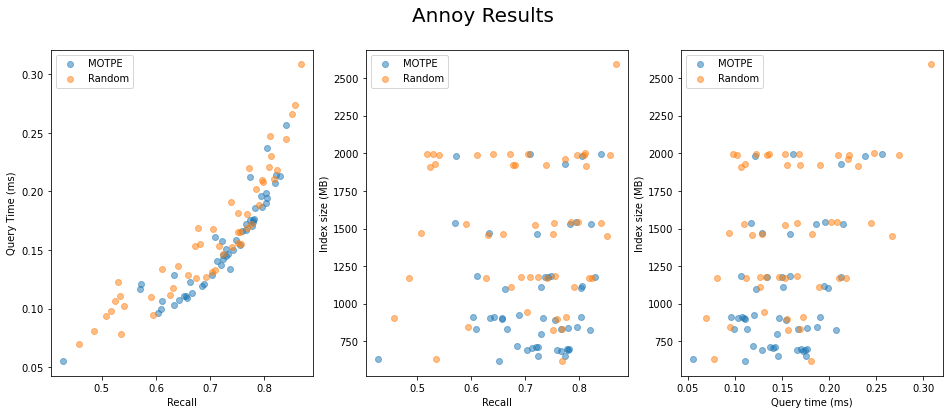

In [11]:
three_panel_fig([annoy_motpe_df, annoy_random_df])#
#threeD_fig([motpe_df, random_df])

### Discussion time
Let's unpack this a bit. We had three objectives to optimize: recall, latency, and memory. In the figure above we show the relationship between all possible combinations of objectives (rather than showing a 3D scatter plot, which, while cool, is harder to glean useful information from. If you're hankering for some 3D, uncomment the other fig command and have at it).

The leftmost panel shows the resulting `query_time` vs `recall` and a lovely curve demonstrating the trade-off between these two objectives.  The blue MOTPE points seem to be more densely clustered closer to the edge of the latency-recall Pareto frontier. However, the orange points sample it well enough. That these two distributions are so similar is not actually a surprise. It turns out that the `search_k` parameter is explicitly designed to directly control this trade-off: larger values of `search_k` result in higher accuracy _and_ longer query times. This means that tracing out the Pareto frontier is almost entirely a matter of fixing `n_trees` (our other hyperparameter), and sweeping over `search_k`. The results would yield a similar curve. 

If those were the only two objectives we cared about, we'd be done! But since we also care about memory, the problem is a bit more complex. In the middle and third panels, we see Index size (in MB) vs the other two objectives, and here we see a bit more difference between the MOTPE algorithm and randomly sampled hyperparameter values. The MOTPE algorithm better samples the regions we care about (low memory, fast query times, and high recall), but it's not always a significant difference, even when we run for many more trials! 

![Annoy 100 trials](images/Annoy_100trials_blog.png)

Some other things to note: 
1. To run the optimization in a realistic amount of time, we provided the Annoy algorithm with artifically low values for its hyperparameters. The algorithm is fairly competitive and can achieve much better recall on the GloVe dataset. However, the build and query times associated with these preferrable hyperparameter values result in an optimization time on the order of several hours. It a pesky, double-edged sword: while we want to demonstrate realistic use cases / algorithms / datasets, they come with realistic compute times which are _considerable_. 
2. It's important to keep in mind that it may not be physically possible to densely sample the entire 3D output objective volume -- there is no guarantee that combinations of hyperparameters exist such that all white space could be covered by orange or blue points. 

So why didn't MOBO run circles around random search? Maybe Annoy doesn't have enough hyperparameters to optimize over. Maybe it's just too simple. We'll come back to this discussion towards the end. For now, let's try our next ANN, which has three hyperparameters. 

## Hierarchical Navigable Small Worlds

A classic brute-force method for computing nearest neighbors to a query point is to construct a KNN graph. While these work great for small datasets, they don't scale well to millions of points. Enter Hierarchical Navigable Small Worlds (HNSW) graphs. The name says a lot so let's break it down. 

A "small world" graph (or network) is one in which the nodes are highly clustered (most nodes are not neighbors of one another), but the _neighbors_ of any give node are likely to be neighbors of _each other_, resulting in a graph in which most nodes can be reached by every other node in only a few steps. While that might seem paradoxical, think of the distribution of air traffic. Planes fly mostly from busy, centralized hubs (highly clustered), and it only takes a few stop-overs to go from your local airport to just about any major city in the world. 

If we could structure our dataset in such a way that it has the properties of a small world graph, we'd be in decent shape because we could quickly find neighbors anywhere in the graph in a small number of steps. In practice, though, that's not enough. Tracing along the nodes in a graph still takes linear time (it takes _n_ time steps to move _n_ nodes). However, if a small world graph is also _navigable_ then it possesses an additional property: routing through the graph can be done on a logarathimic scale (those same _n_ nodes can now be traversed in only _log(n)_ time), which is much faster! But we can do even better.

We finally come to the "heirarchical" part. The HNSW algorithm constructs a hierarchy of NSW graphs. The first layer is a graph of all the points in our database, where each point is connected to others on a small, characteristic scale length. Next, a subset of these points is kicked up to a second layer, where these points are connected via a slightly longer scale length. Then a subset of this subset is kicked up to a third layer with an even larger scale length connection, and so on. 

![HNSW](images/hnsw3.png)

When a query comes in, the algorithm starts at the top layer, greedily searching for nearest neighbors on the graph with the longest scale length. The results of this layer are then passed down to the layer below, where new, closer neighbors are found. This continues until the algorithm reaches lowest layer, finally returning the closest neighbors.  


### Hyperparameters
We'll use the [hnswlib](https://github.com/nmslib/hnswlib) library for this algorithm. This implementation has three tunable hyperparameters. 
* `ef` sets the size of the dynamic list of candidates to evaluate at query time. This parameter affects the latency-recall trade-off, where large values of `ef` yield better accuracy but longer query times. 
* `ef_construction`: This has the same meaning as `ef` but during the construction phase. It influences the construction time as well as the quality of the index. Larger values result in a better index but take longer to build.  
* `M`: this sets the number of bidirectional connections between nodes in the graph. More nodes mean more memory usage but also better connections between other nodes. Larger values of `M` are often better for high-dimensional vectors (like the word embeddings we're using).  


### Code it up
Very little changes from our previous function! We still initialize and populate an index even though, behind the scenes, the algorithm is constructing a very different object from the Annoy algorithm. 

In [12]:
def train_hnsw(trial): 
    
    ann = hnswlib.Index(space='cosine', dim=X_train.shape[1])
    
    num_elements = len(X_train)
    
    # Initializing index - the maximum number of elements should be known beforehand
    memory_usage_before = get_memory_usage(os.getpid())
    ann.init_index(max_elements = num_elements, 
                   ef_construction = trial.suggest_int("ef_construction", 10, 100), 
                   M = trial.suggest_int("M", 2, 50)
                  )
    # Element insertion 
    ann.add_items(X_train, np.arange(num_elements))
    index_size = get_memory_usage(os.getpid()) - memory_usage_before

    # control the recall (ef should always be >= N_NEIGHBORS)
    ann.set_ef(trial.suggest_int("ef", 10, 100)) 

    # run queries for each example in the test set
    t1 = time.time()
    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    neighbors, _ = ann.knn_query(X_test, k = N_NEIGHBORS)
    query_time = (time.time() - t1) / len(X_test)

    recall = compute_recall(neighbors, X_test_neighbors)
    
    return recall, query_time, index_size

In [13]:
# NOTE: this cell takes about an hour to run
motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler,
                                       directions=["maximize", "minimize", "minimize"])
motpe_experiment.optimize(train_hnsw, n_trials=N_TRIALS)

<ipython-input-13-1db9ede7d8eb>:1: ExperimentalWarning: MOTPESampler is experimental (supported from v2.4.0). The interface can change in the future.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2021-06-24 19:03:32,672] A new study created in memory with name: no-name-95a55001-4570-4d8f-9543-c0a88604b11a
[I 2021-06-24 19:03:43,053] Trial 0 finished with values: [0.26542999999999495, 8.561468124389648e-06, 674.1875] and parameters: {'ef_construction': 51, 'M': 2, 'ef': 71}. 
[I 2021-06-24 19:06:18,716] Trial 1 finished with values: [0.991349999999999, 7.11815357208252e-05, 1399.38671875] and parameters: {'ef_construction': 32, 'M': 96, 'ef': 33}. 
[I 2021-06-24 19:06:45,629] Trial 2 finished with values: [0.784400000000004, 1.891188621520996e-05, 622.87890625] and parameters: {'ef_construction': 39, 'M': 10, 'ef': 33}. 
[I 2021-06-24 19:08:59,683] Trial 3 finished with values: [0.9920599999999989, 7.491040229797363e-05, 1309.55078125] and parameters: {'ef_construction': 79, 'M': 

[I 2021-06-24 20:06:49,033] Trial 42 finished with values: [0.9911199999999997, 7.964971065521241e-05, 738.58984375] and parameters: {'ef_construction': 53, 'M': 25, 'ef': 90}. 
[I 2021-06-24 20:08:01,295] Trial 43 finished with values: [0.9795499999999984, 5.242159366607666e-05, 658.45703125] and parameters: {'ef_construction': 78, 'M': 16, 'ef': 71}. 
[I 2021-06-24 20:09:23,540] Trial 44 finished with values: [0.9883000000000002, 7.203876972198486e-05, 704.921875] and parameters: {'ef_construction': 79, 'M': 21, 'ef': 68}. 
[I 2021-06-24 20:12:36,768] Trial 45 finished with values: [0.9993, 0.00015685410499572755, 1380.41796875] and parameters: {'ef_construction': 62, 'M': 96, 'ef': 82}. 
[I 2021-06-24 20:13:03,193] Trial 46 finished with values: [0.7359600000000042, 2.223978042602539e-05, 560.40234375] and parameters: {'ef_construction': 57, 'M': 5, 'ef': 71}. 
[I 2021-06-24 20:13:58,171] Trial 47 finished with values: [0.9367900000000003, 4.296810626983643e-05, 623.61328125] and pa

In [14]:
# Note: this cell can take 1-2 hours to run
random_sampler = optuna.samplers.RandomSampler()
random_experiment = optuna.create_study(sampler=random_sampler, directions=["maximize", "minimize", "minimize"])
random_experiment.optimize(train_hnsw, n_trials=N_TRIALS)

[I 2021-06-24 20:25:37,665] A new study created in memory with name: no-name-a68eff9b-eb2b-4f18-bfc7-d4165162ea33
[I 2021-06-24 20:28:06,180] Trial 0 finished with values: [0.983939999999999, 5.984342098236084e-05, 1276.7578125] and parameters: {'ef_construction': 84, 'M': 85, 'ef': 29}. 
[I 2021-06-24 20:28:44,845] Trial 1 finished with values: [0.979860000000001, 7.119548320770264e-05, 804.00390625] and parameters: {'ef_construction': 36, 'M': 32, 'ef': 89}. 
[I 2021-06-24 20:30:52,545] Trial 2 finished with values: [0.9822999999999993, 7.502460479736328e-05, 1203.10546875] and parameters: {'ef_construction': 37, 'M': 77, 'ef': 32}. 
[I 2021-06-24 20:32:44,439] Trial 3 finished with values: [0.9970999999999997, 9.25718069076538e-05, 884.734375] and parameters: {'ef_construction': 81, 'M': 41, 'ef': 77}. 
[I 2021-06-24 20:32:59,959] Trial 4 finished with values: [0.7970900000000032, 2.7109718322753907e-05, 668.33984375] and parameters: {'ef_construction': 15, 'M': 17, 'ef': 47}. 
[I 2

[I 2021-06-24 22:02:40,147] Trial 43 finished with values: [0.8827200000000018, 2.7303791046142577e-05, 902.71875] and parameters: {'ef_construction': 25, 'M': 43, 'ef': 20}. 
[I 2021-06-24 22:04:13,108] Trial 44 finished with values: [0.9580099999999994, 4.920849800109863e-05, 1110.40234375] and parameters: {'ef_construction': 64, 'M': 66, 'ef': 28}. 
[I 2021-06-24 22:06:12,731] Trial 45 finished with values: [0.9991300000000001, 0.0001390671968460083, 1218.75] and parameters: {'ef_construction': 55, 'M': 78, 'ef': 92}. 
[I 2021-06-24 22:07:12,461] Trial 46 finished with values: [0.9388200000000008, 3.362522125244141e-05, 631.83984375] and parameters: {'ef_construction': 84, 'M': 13, 'ef': 50}. 
[I 2021-06-24 22:07:54,610] Trial 47 finished with values: [0.795320000000003, 1.5109610557556152e-05, 695.0390625] and parameters: {'ef_construction': 46, 'M': 20, 'ef': 14}. 
[I 2021-06-24 22:10:18,765] Trial 48 finished with values: [0.9802700000000001, 5.933408737182617e-05, 1327.11328125]

In [16]:
hnsw_motpe_df = cast_as_df(motpe_experiment, experiment_type="MOTPE", algorithm_name="HNSW")
hnsw_random_df = cast_as_df(random_experiment, experiment_type="Random", algorithm_name="HNSW")

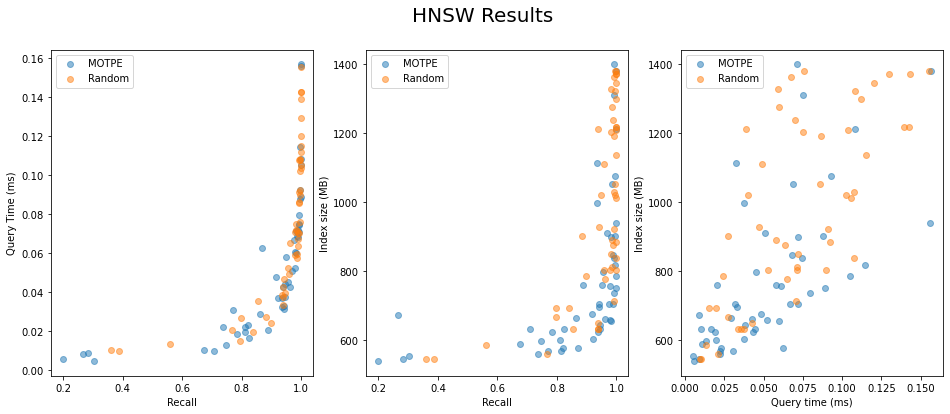

In [17]:
three_panel_fig([hnsw_motpe_df, hnsw_random_df])#

### Discussion time

Results are essentially the same with this algorithm. Even though we have more hyperparameters (3 for HNSW vs only 2 for Annoy), random sampling is able to effectively cover similar regions of the objective space. Again, we ran this experiment for 100 trials (which took a looong time). 

![HNSW 100 trials](images/HNSW_100trials_blog.png)


One intriguing difference is in the middle figure where the MOTPE algorithm identifies a few models that seem to dominate the memory space (having much lower memory than all other models) but this is likely a fluke because the way we  measure memory usage of the algorithm is not exact. 


## Locality-sensitive Hashing

A _hash function_ maps high-dimensional data to fixed-size low-dimensional representations. The outputs of hash functions are typically used as keys into _hash tables_.  In cryptography and security applications, hash functions are designed such that two datapoints (ideally) never map to the same output. But _locality-sensitive_ hash functions do just the opposite -- they are designed such that similar data points _collide_ with high probability, that is, they land in the same _bucket_. Thus, hash functions are another method to partition our dataset, reducing the amount of computation.  LSH strives to ensure similar points fall into the same bucket, and dissimilar points land in other buckets. At query time, we apply our hash function to the incoming query, match the hash output to the corresponding bucket, and examine only those database points residing in that same bucket.  
<img src="https://miro.medium.com/max/2248/1*ph214h94u43vgb9A4FwHXw.png">

In reality, multiple hash functions are used, each resulting in a slightly different partitioning of the space.   When the query comes in, each hash function is applied to the query point and candidates from the matching bucket from _each_ hash table are retrieved.  

A hash table can have lots of buckets or only a few buckets, determined by the number of _bits_. More bits equal more buckets. More buckets result in a finer partitioning of the space. For example, imagine we randomly mapped each point in our database to either 0 or 1 (two bits = two buckets). We'd have approximately half our database in each bucket. When performing a query, we'll retrieve all the members of, say, bucket 0. We'll still have to compute the distances between our query and _half_ the points in our database! Therefore, more bits usually reduces the query time by thinning out the number of candidates in each bucket. 

### Hyperparameters
While there are literally dozens of implementations, most versions (including the version we use) have the following hyperparameters to consider: 

* `number_of_hash_tables`: More hash tables lead to better accuracy but increased memory footprint.  
* `number_of_hash_bits`: The number of hash bits determines the number of buckets per table; more buckets decreases query time but increases the memory footprint. 
* `number_of_probes`: At query time, we can examine multiple buckets from each hash table to find nearest neighbor candidates. More probes leads to great accuracy but the query will take longer. 


### Code it up
We're using the [FALCONN](https://github.com/FALCONN-LIB/FALCONN) library for LSH (in case you're wondering, FALCONN is the decidedly awkward acronym for FAst Lookups of Cosine and Other Nearest Neighbors). We found this library to be a bit finicky, and it requires a sizeable amount of prepwork before index initialization. We borrowed from [this example](https://github.com/FALCONN-LIB/FALCONN/blob/master/src/examples/glove/glove.py), where you can find more details about these additional (non-tunable) parameters. 

**Special note:** This algorithm is structured in such a way that the `number_of_probes` used at query time _must_ be at least as large as the `number_of_tables`. This means we have one hyperparameter that is directly dependent on another! Thankfully, Optuna handles this use case with aplomb! Optuna's enables define-by-run optimization which means that each trial is generated entirely independently from others. Instead of assigning our HPs inline as in the previous examples, we'll handle them at the top of the function.

In [18]:
def train_lsh(trial):
    
    # Handle hyperparameter suggestions
    num_tables = trial.suggest_int("number_of_tables", 10, 50)
    # num_probes depends on num_tables -- 
    # We can directly pass Optuna's num_tables suggestion to the num_probes generator
    num_probes = trial.suggest_int("number_of_probes", num_tables, num_tables*2) 
    # Don't allow num_bits > 28 or falconn will throw an error
    num_bits = trial.suggest_int("number_of_hash_bits", 12, 26)
    
    # LSH initialization (For more details see link to example above)
    params = falconn.LSHConstructionParameters()
    params.dimension = len(X_train[0])
    params.lsh_family = falconn.LSHFamily.CrossPolytope
    params.distance_function = falconn.DistanceFunction.EuclideanSquared
    params.num_rotations = 1
    params.seed = 5721840 
    params.num_setup_threads = 0 # use all available threads
    params.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
    # Set build-related hyperparameters
    params.l = num_tables
    falconn.compute_number_of_hash_functions(num_bits, params)

    # LSH index construction
    memory_usage_before = get_memory_usage(os.getpid())
    table = falconn.LSHIndex(params)
    table.setup(X_train)
    index_size = get_memory_usage(os.getpid()) - memory_usage_before

    # Set up the query object with num_probes
    query_object = table.construct_query_object(num_probes=num_probes) 
    
    # Perform the queries
    t1 = time.time()
    neighbors = []
    for i, x in enumerate(X_test):
        neighbors.append(query_object.find_k_nearest_neighbors(x, N_NEIGHBORS))
    query_time = (time.time() - t1) / len(X_test)
                         
    # Evaluate
    recall = compute_recall(neighbors, X_test_neighbors)

    return recall, query_time, index_size

In [21]:
# Note: this cell takes about 20 minutes to run
motpe_sampler = optuna.samplers.MOTPESampler()
motpe_experiment = optuna.create_study(sampler=motpe_sampler,
                                       directions=["maximize", "minimize", "minimize"])
motpe_experiment.optimize(train_lsh, n_trials=N_TRIALS)

<ipython-input-21-236ef6d9d285>:1: ExperimentalWarning: MOTPESampler is experimental (supported from v2.4.0). The interface can change in the future.
  motpe_sampler = optuna.samplers.MOTPESampler()
[I 2021-06-25 09:51:36,492] A new study created in memory with name: no-name-4bbb0127-2e15-433d-9c12-3219ddfe1e92
[I 2021-06-25 09:52:09,918] Trial 0 finished with values: [0.8797599999999849, 0.002646678829193115, 168.66796875] and parameters: {'number_of_tables': 48, 'number_of_probes': 65, 'number_of_hash_bits': 15}. 
[I 2021-06-25 09:52:31,149] Trial 1 finished with values: [0.4578599999999973, 0.00046552860736846926, 2718.35546875] and parameters: {'number_of_tables': 43, 'number_of_probes': 83, 'number_of_hash_bits': 24}. 
[I 2021-06-25 09:52:41,046] Trial 2 finished with values: [0.37286999999998993, 0.00021935951709747316, 742.484375] and parameters: {'number_of_tables': 23, 'number_of_probes': 44, 'number_of_hash_bits': 23}. 
[I 2021-06-25 09:52:56,552] Trial 3 finished with values

[I 2021-06-25 10:04:02,085] Trial 36 finished with values: [0.9164999999999814, 0.004724530696868896, 174.75] and parameters: {'number_of_tables': 47, 'number_of_probes': 92, 'number_of_hash_bits': 14}. 
[I 2021-06-25 10:04:17,020] Trial 37 finished with values: [0.6072200000000012, 0.0004701333045959473, 310.43359375] and parameters: {'number_of_tables': 42, 'number_of_probes': 58, 'number_of_hash_bits': 20}. 
[I 2021-06-25 10:04:30,403] Trial 38 finished with values: [0.659839999999997, 0.0005370358943939208, 139.46484375] and parameters: {'number_of_tables': 32, 'number_of_probes': 43, 'number_of_hash_bits': 18}. 
[I 2021-06-25 10:05:35,044] Trial 39 finished with values: [0.9189799999999837, 0.005846633505821228, 144.9609375] and parameters: {'number_of_tables': 38, 'number_of_probes': 74, 'number_of_hash_bits': 13}. 
[I 2021-06-25 10:05:50,321] Trial 40 finished with values: [0.6989299999999935, 0.0006446422576904297, 164.7109375] and parameters: {'number_of_tables': 39, 'number_o

In [22]:
# Note: this cell takes about 20 minutes to run
random_sampler = optuna.samplers.RandomSampler()
random_experiment = optuna.create_study(sampler=random_sampler, directions=["maximize", "minimize", "minimize"])
random_experiment.optimize(train_lsh, n_trials=N_TRIALS)

[I 2021-06-25 10:16:26,401] A new study created in memory with name: no-name-fba75b23-62b5-45e2-8188-8631152733c7
[I 2021-06-25 10:16:46,174] Trial 0 finished with values: [0.7781999999999899, 0.0010494932889938355, 146.73046875] and parameters: {'number_of_tables': 40, 'number_of_probes': 55, 'number_of_hash_bits': 17}. 
[I 2021-06-25 10:17:21,762] Trial 1 finished with values: [0.2764099999999897, 0.00046885650157928464, 5098.8984375] and parameters: {'number_of_tables': 34, 'number_of_probes': 61, 'number_of_hash_bits': 26}. 
[I 2021-06-25 10:17:46,242] Trial 2 finished with values: [0.8394799999999893, 0.0018278647184371947, 114.30078125] and parameters: {'number_of_tables': 34, 'number_of_probes': 45, 'number_of_hash_bits': 15}. 
[I 2021-06-25 10:18:55,244] Trial 3 finished with values: [0.9209299999999814, 0.0062559912919998165, 155.18359375] and parameters: {'number_of_tables': 41, 'number_of_probes': 75, 'number_of_hash_bits': 13}. 
[I 2021-06-25 10:19:12,738] Trial 4 finished 

[I 2021-06-25 10:31:32,167] Trial 37 finished with values: [0.8966099999999849, 0.003543233299255371, -490.703125] and parameters: {'number_of_tables': 49, 'number_of_probes': 58, 'number_of_hash_bits': 14}. 
[I 2021-06-25 10:31:54,924] Trial 38 finished with values: [0.8315899999999902, 0.001818433904647827, 110.1484375] and parameters: {'number_of_tables': 25, 'number_of_probes': 47, 'number_of_hash_bits': 15}. 
[I 2021-06-25 10:32:14,844] Trial 39 finished with values: [0.20976999999999385, 0.00020131540298461915, 3590.08984375] and parameters: {'number_of_tables': 21, 'number_of_probes': 40, 'number_of_hash_bits': 26}. 
[I 2021-06-25 10:32:21,519] Trial 40 finished with values: [0.21414999999999368, 0.00012017819881439209, 779.625] and parameters: {'number_of_tables': 14, 'number_of_probes': 15, 'number_of_hash_bits': 23}. 
[I 2021-06-25 10:32:28,350] Trial 41 finished with values: [0.4030499999999927, 0.0001993230104446411, -12.57421875] and parameters: {'number_of_tables': 14, 'n

In [23]:
lsh_motpe_df = cast_as_df(motpe_experiment, experiment_type="MOTPE", algorithm_name="LSH")
lsh_random_df = cast_as_df(random_experiment, experiment_type="Random", algorithm_name="LSH")

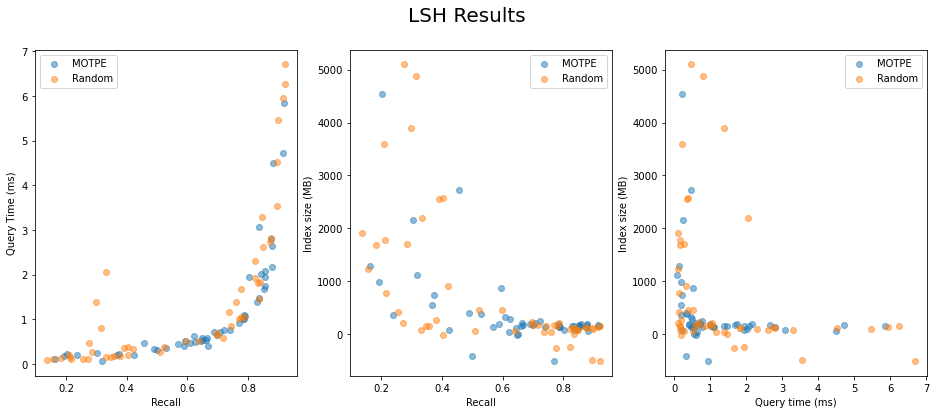

In [24]:
three_panel_fig([lsh_motpe_df, lsh_random_df])#

### Discussion time
These figures look much the same as previous experiments: both MOTPE and random sampling more or less trace out the same region of objective space. Again, we find a few points that seem to dominate the memory space but again we caution that this is likely due to the nature in which we measure memory (in fact, we know some of these measurements are completely wrong because they're negative!). We use the `psutil` library and pass it the process PID to measure the memory usage before and after building the index. While this works well enough for Annoy and HNSW, we suspect this LSH implementation does not always fully release memory upon a new iteration of a trial during the optimization run. This would cause the next pass through the training loop to still register memory from the previous loop, thus resulting in an incorrect measurement. We were unable to track down the exact cause -- if we figure it out, we'll fix it! (And if you spot the problem, let us know!) 

![LSH 100 trials](images/LSH_150trials_blog.png)
To be consistent, we again ran this experiment for many more trials (150 this time). While we can see Pareto frontier is very densely sampled by the MOBO strategy, random search still does a fine job of covering the space. 



## Optimizing ANNs without MOBO
We used ANNs to demonstrate a real-world, complex, data-intensive application with realistic multi-objective goals. This allowed us to explore the nuances of multi-objective optimization on more than a toy problem. But we ultimately discovered that even in such a setting, multi-objective Bayesian optimization does not typically perform significantly better than random sampling.  However, if you are building an ANN application (rather than reading along for a detailed look at MOBO) then we can do even better than random sampling. 

In real ANN applications, often the memory budget is already known (or is cheap enough that additional resources can be easily procured). If you already know your memory budget, then there is no need to optimize over it. For most ANN algorithms, the memory budget can be set to your specifications with a little fiddling (think `M` in the case of HNSW, or `number_of_hash_tables` in LSH). Once set, perform a simple sweep over the hyperparameter that controls the latency-recall tradeoff (`search_k` in Annoy, `ef` in HNSW, `number_of_probes` in LSH). And voila! This hyperparameter sweep will inherently trace out a Pareto frontier in Recall/Query time space. However, if you do not know _a priori_ what memory budget you are willing to allot for your application, the next best thing would be to perform a random sampling of the hyperparameters of your algorithm to get a feel for the trade-offs involved. 

Another interesting axis we didn't dig into in this post is an ANN algorithm's _build time_. We looked closely at _query time_, which is typically more important. In this notebook, we artifically set the range of hyperparameter values such that cells won't take hours or _days_ to run (resulting in some rather low values of Recall, if you noticed). However, in a real application, building the search index for one of these algorithms can take a considerable amount of time when more appropriate HPs are employed and even larger datasets are used. This matters if an application will require _rebuilding_ on a regular cadence. While some algorithms allow insertion of new datapoints, better results are often achieved by occasionally rebuilding the index, especially if many new items are to be added. 

A good example is tweets. More than 500 million new tweets are added to Twitter each day. Simple insertion of these new tweets to an existing index may be suboptimal. In which case, a regular rebuilding cadence should be established and the build time for such an algorithm becomes important. Therefore, some applications may require a careful analysis of the trade-off of build time with recall, query time, and memory footprint -- a 4D optimization problem! However, as with the memory footprint, an acceptable build time budget may already be known _a priori_ and hyperparameters can be set such that they meet memory and build time requirements. Then, simply sweep over the latency-recall trade-off hyperparameter to identify the Pareto frontier between predictive performance and inference time.

## The big take-away

We applied multi-objective Bayesian optimization to three Approximate Nearest Neighbor algorithms and found that the results weren't always much better than using a random sampling. And this is not altogether unsurprising. In a [recent paper](https://arxiv.org/pdf/2012.03826.pdf), authors demonstrated that many MOBO algorithms only perform HPO a few percent better (in terms of optimizing an appropriate objective like accuracy) than random sampling on a wide range of machine learning experiments. 

While its still unclear when MOBO might provide significant gains over random sampling, one clue may be in the relationship of the hyperparameters to the objective space. Algorithms like neural networks have many parameters with complex and non-linear relationships between them and the objective (such as accuracy or latency). The myriad hyperparameter combinations could very well map to a vast space of possible (accuracy, latency) outputs (like on the right). However, this might not hold true for all algorithms, where the actual possible output space is constrained (like on the left).  


![Output spaces](images/output_space_cartoon.png)


We speculate that MOBO optimization techniques stand a chance of performing better when the output space is like that on the right. The sophisticated mechanisms in these techniques should be better able to identify more ideal points in the output space over a random algorithm which samples, well... randomly! But when the output space is constrained, both MOBO and random search have "less room" to sample, so random performs about as well as these more sophisticated techniques. 


![Output spaces with MOBO (blue) and random (orange) samples](images/output_space_samples.png)

The hyperparameters of many approximate nearest neighbor algorithms may provide their own constraints, because they often control a single objective. For example, `M` in the HNSW algorithm is almost entirely responsible for the memory footprint. This means that, regardless of the value of other hyperparmeters, the memory output is more or less fixed, constraining the possible outputs in the objective space. The same is true for the hyperparameters that control the accuracy-latency trade-off. Thus, when we plot these results we see both random and MOBO algorithms perform similarly because there simply isn't that much output space to explore. 

The ultimate lesson from our experiments in this and our previous notebooks is that random sampling is probably good enough for most applications. Using more sophisticated optimization techniques may provide added benefit when the relationship between your hyperparameters and the objective space is murky, or when you have a large compute budget. The longer these experiments are run, the more likely the MOBO algorithm is to find marginally better solutions and sometimes even a marginal improvement is worth the computational cost. 